# Compare the optimized architecture to the actual architecture:

Import all necessary packages:

In [79]:
# Jupyter packagesb
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

# Common packages, you know them from before 
import matplotlib.pyplot as plt
from keras.callbacks import EarlyStopping
import pandas as pd
import numpy as np
import tensorflow as tf
import random
import math
import copy
from typing import *
import json
import string
import os
import pickle
from pymoo_implementation.problem.problem_mlp_optimization import create_MLP_from_parameter

# Setup jupyter
%matplotlib inline

In [80]:
PATH = (os.getcwd().replace("scripts", ""))
PICKLE_NAME = f"{PATH}pickled_data/res-ITIV-set1-20pop-5ly-2023-02-14.p"

Set constants:

In [81]:
TRAIN_DATA_COUNT = 500000
EVALUTAION_DATA_COUNT = TRAIN_DATA_COUNT

In [82]:
# Data constants
data_path_1 = PATH + "data/random1"
data_path_2 = PATH + "data/random2"
data_path_3 = PATH + "data/random3"
path_list = [data_path_1, data_path_2, data_path_3]

Read the data:

In [83]:
def get_data(data_path : string, data_count: int): 
    original_data = pd.read_csv(data_path, delimiter='\t');
    data = original_data.iloc[:
    data_count
    , 9:]
    input = data.iloc[:, :-9]
    target = data.iloc[:, -9:-7]

    return input, target, len(original_data)

input, target, lenght = get_data(data_path_3, TRAIN_DATA_COUNT)
val_input, val_target, lenght = get_data(data_path_1, EVALUTAION_DATA_COUNT)

In [84]:
def data_prep(model, input, target):    
    y_pred = model.predict(input)

    z_list = np.array([])
    theta_list = np.array([])

    true_z_list = np.array([])
    true_theta_list = np.array([])

    for element in y_pred:
        z_list = np.append(z_list, element[0]) 
        theta_list = np.append(theta_list, element[1])

    for element in target.values:
        true_z_list = np.append(true_z_list, element[0]) 
        true_theta_list = np.append(true_theta_list, element[1])
    
    return z_list * 100, true_z_list * 100

Load the model:

In [85]:
def load_model(input_data, target_data, parameter):
    # add early stopping callback to save time
    es = EarlyStopping(monitor = 'val_accuracy', mode ='max', patience = 5)
    # Train the model
    cnn_model = create_MLP_from_parameter(parameter)
    cnn_model.fit(input_data, target_data, epochs=500, validation_split = 0.2, batch_size=2, callbacks = [es], use_multiprocessing=True, verbose=0)

    return cnn_model

In [86]:
res = pickle.load(open(PICKLE_NAME, "rb"))
for history in res:
        last_best = history[-1].opt.get("F")  
        pop = history[-1].opt.get("X")    
        print (last_best)
        print (pop)

[[ -0.93437499  64.         322.        ]
 [ -0.92500001   1.          12.        ]
 [ -0.93124998   3.           9.        ]
 [ -0.92624998   2.          22.        ]
 [ -0.9325      18.          33.        ]
 [ -0.92062497   4.           8.        ]
 [ -0.93000001   5.           5.        ]]
[[36. 28.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.]
 [ 2.  1.  0.  0.  0.]
 [ 2.  0.  0.  0.  0.]
 [ 4.  7.  7.  0.  0.]
 [ 2.  2.  0.  0.  0.]
 [ 2.  1.  2.  0.  0.]]


In [87]:
# choose the best solution (best acc) from the above:
opt_parameter = pop[4]
opt_parameter

array([4., 7., 7., 0., 0.])

In [88]:
opt_model = load_model(input, target, opt_parameter)
old_model = load_model(input, target, np.array([81]))

Plot generations in scatter plot:

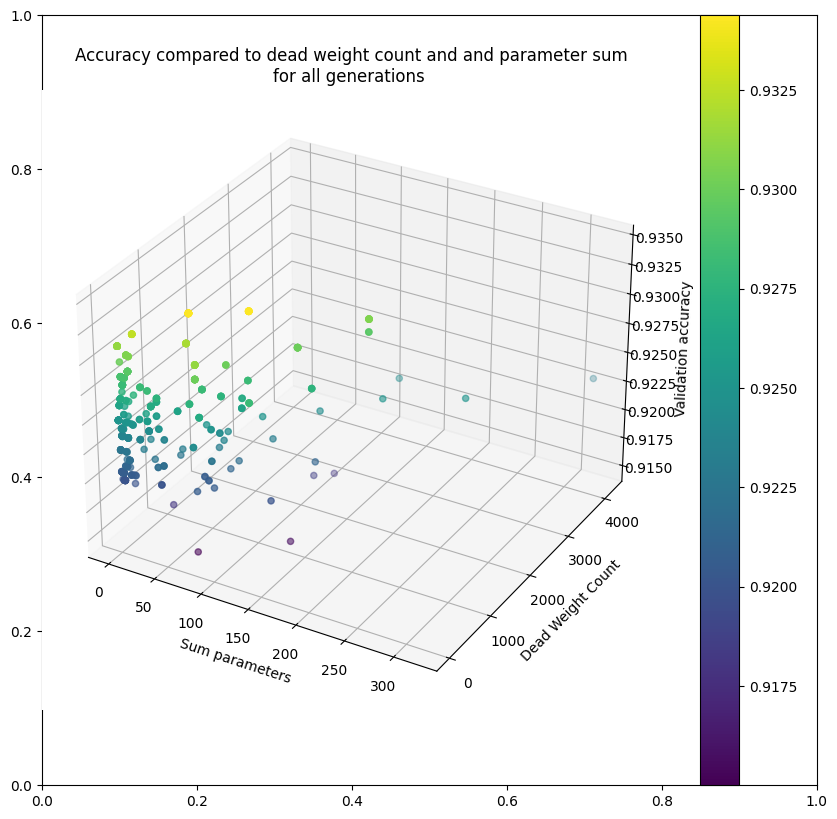

In [89]:
def get_generation_plot(pickle_name, save_name):
    fig, ax = plt.subplots(1, 1)
    fig.set_size_inches(10, 10)

    history_list = pickle.load( open(pickle_name, "rb"))

    for entry in history_list[0]:
        F = []
        # for each algorithm object in the history
        for result_history in history_list:

            # for each algorithm object in the history
            for entry in result_history:
                if (len(F) == 0):
                    F = (entry.pop.get("F"))
                else:
                    F = np.append(F, entry.pop.get("F"),axis=0)   

    acc = [-i[0] for i in F]
    sum =  [i[1] for i in F]
    dWc =  [i[2] for i in F]

    ax = plt.axes(projection = '3d')
    plot = ax.scatter(sum, dWc, acc, c=acc, cmap='viridis')
    ax.set_ylabel("Dead Weight Count")
    ax.set_xlabel("Sum parameters")
    ax.set_zlabel("Validation accuracy")
    ax.set_title("Accuracy compared to dead weight count and and parameter sum\nfor all generations ")
   
    fig.tight_layout
    fig.colorbar(plot, use_gridspec=True, )
    fig.savefig(f"{PATH}/plots/{save_name}.png")
    plt.show()

get_generation_plot(PICKLE_NAME, f"generation_plot_{opt_parameter}")

Performace comparision plots:

15625/15625 [==============================] - 14s 901us/step
[-52.7575  41.8162  41.8162 ...  10.0226 -14.3643 -14.3643]


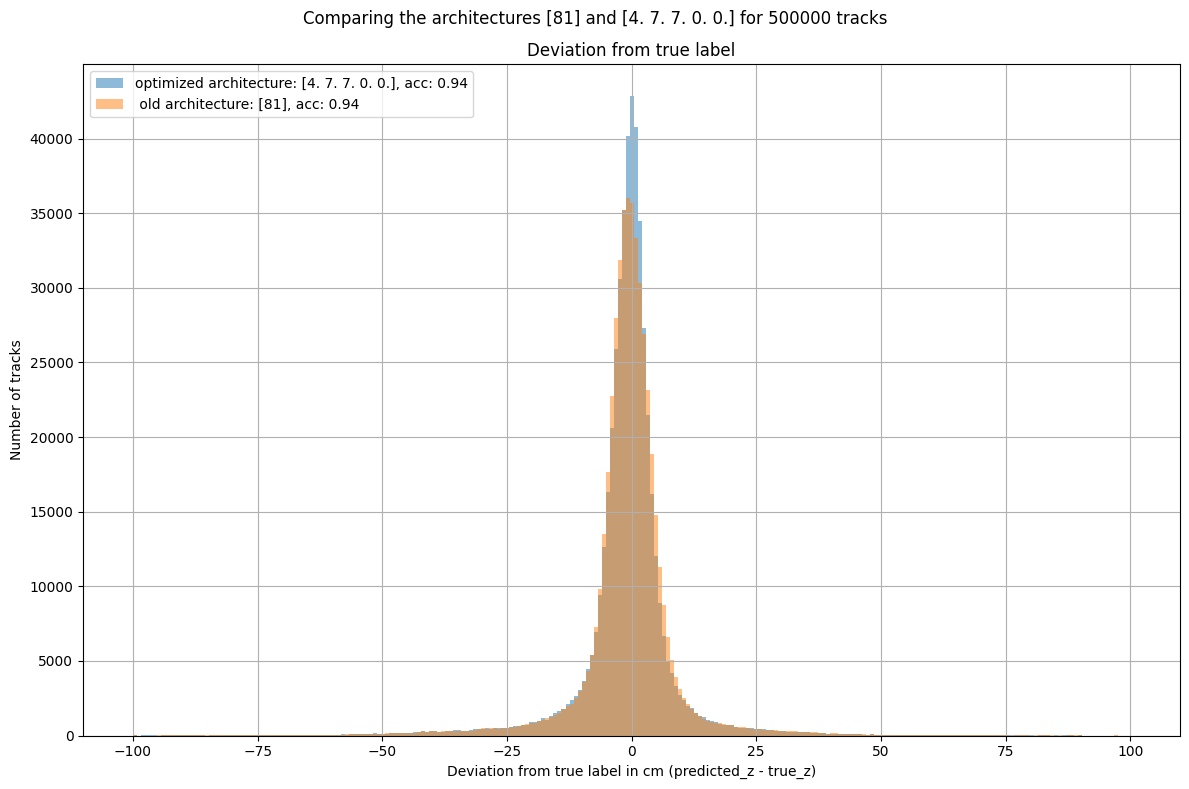

In [90]:
def plot_z_deviation(opt_model,old_model, title, save_name, input, target):
    opt_acc = opt_model.evaluate(input, target)[1]
    old_acc = old_model.evaluate(input, target)[1]
    
    fig, ax = plt.subplots(1, 1)
    hist_bins = np.linspace(-50, 50, 250)
    fig.set_size_inches(12, 8)

    z_list_opt, true_z_list = data_prep(opt_model, input, target)
    z_list_old, true_z_list = data_prep(old_model, input, target)

    delta_z_opt = (z_list_opt).astype(float) - (true_z_list).astype(float)
    delta_z_old = (z_list_old).astype(float) - (true_z_list).astype(float)

    print (true_z_list)
    

    ax.set_title(f'Deviation from true label')
    ax.set_xlabel("Deviation from true label in cm (predicted_z - true_z)")
    ax.set_ylabel("Number of tracks")
    
    ax.hist(delta_z_opt, hist_bins, density=False,  alpha=0.5, label=f'optimized architecture: {opt_parameter}, acc: {opt_acc:0.02f}')
    ax.hist(delta_z_old, hist_bins, density=False,  alpha=0.5, label=f' old architecture: [81], acc: {old_acc:0.02f}')

    ax.grid(True)
    ax.legend(loc = 'upper left')

    fig.suptitle(title)
    plt.tight_layout()
    fig.savefig(f"{PATH}/plots/{save_name}.png")
    plt.show()

plot_z_deviation(opt_model, old_model, f'Comparing the architectures [81] and {opt_parameter} for {EVALUTAION_DATA_COUNT} tracks',  f"2z_deviation_{opt_parameter}", val_input, val_target)

15625/15625 [==============================] - 14s 876us/step


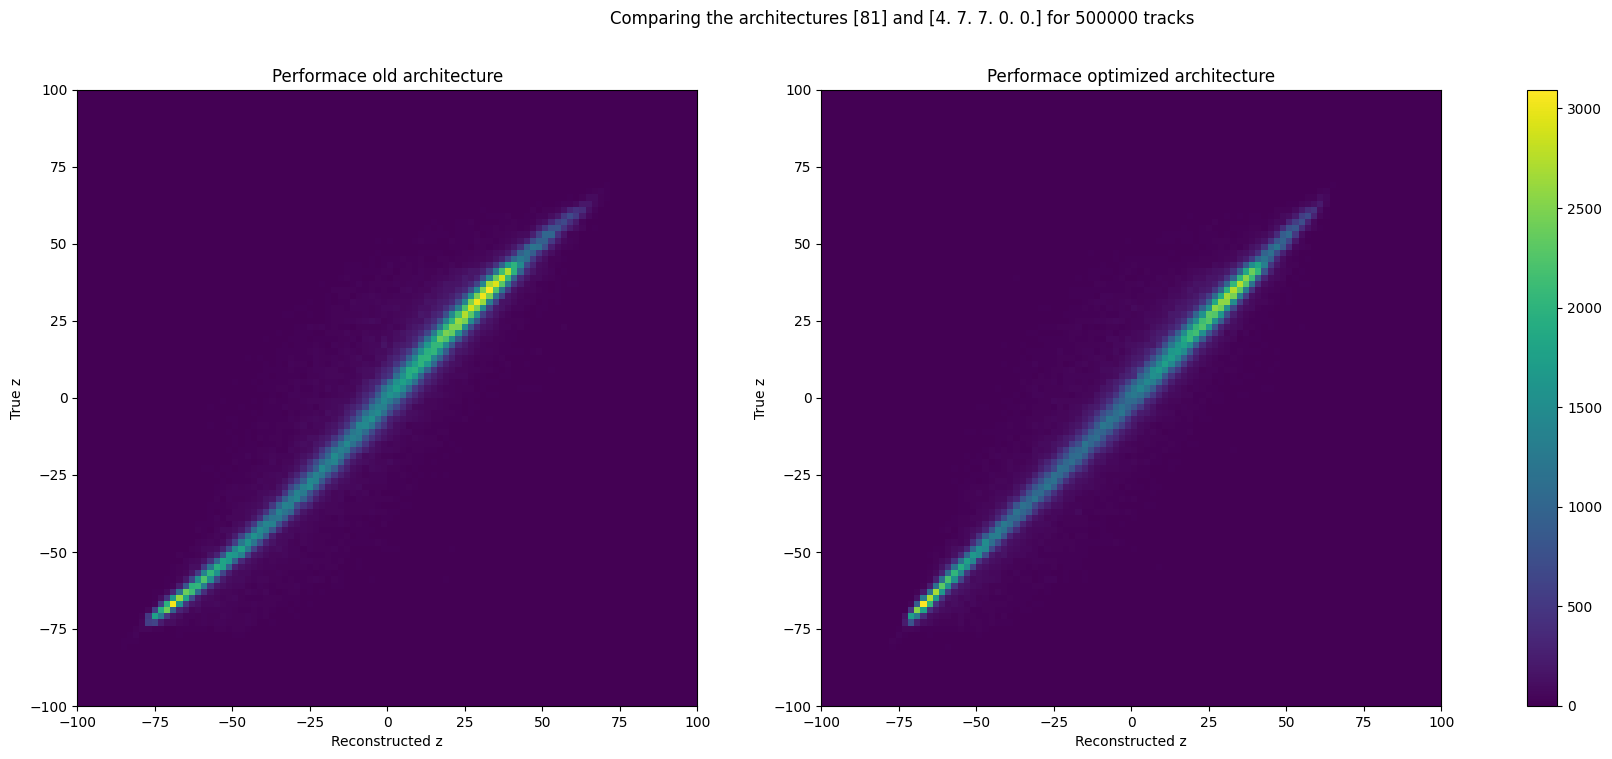

In [91]:
def plot_prediciton_performance(opt_model,old_model, title, save_name, input, target):
    
    fig, ax = plt.subplots(1, 2)
    fig.set_size_inches(22, 8)

    z_list_opt, true_z_list = data_prep(opt_model, input, target)
    z_list_old, true_z_list = data_prep(old_model, input, target)


    ax[0].set_title(f'Performace old architecture')
    ax[0].set_xlabel("Reconstructed z")
    ax[0].set_ylabel("True z")

    ax[0].hist2d(z_list_old, true_z_list, 100, density = False, range=[[-100, 100], [-100, 100]])

    ax[1].set_title(f'Performace optimized architecture')
    ax[1].set_xlabel("Reconstructed z")
    ax[1].set_ylabel("True z")

    plot = ax[1].hist2d(z_list_opt, true_z_list, 100, density = False, range=[[-100, 100], [-100, 100]])
    fig.colorbar(plot[3], ax=ax)

    fig.suptitle(title)
    fig.savefig(f"{PATH}/plots/{save_name}.png")
    plt.show()

plot_prediciton_performance(opt_model, old_model, f'Comparing the architectures [81] and {opt_parameter} for {EVALUTAION_DATA_COUNT} tracks',  f"performace_{opt_parameter}", val_input, val_target)

15625/15625 [==============================] - 14s 894us/step


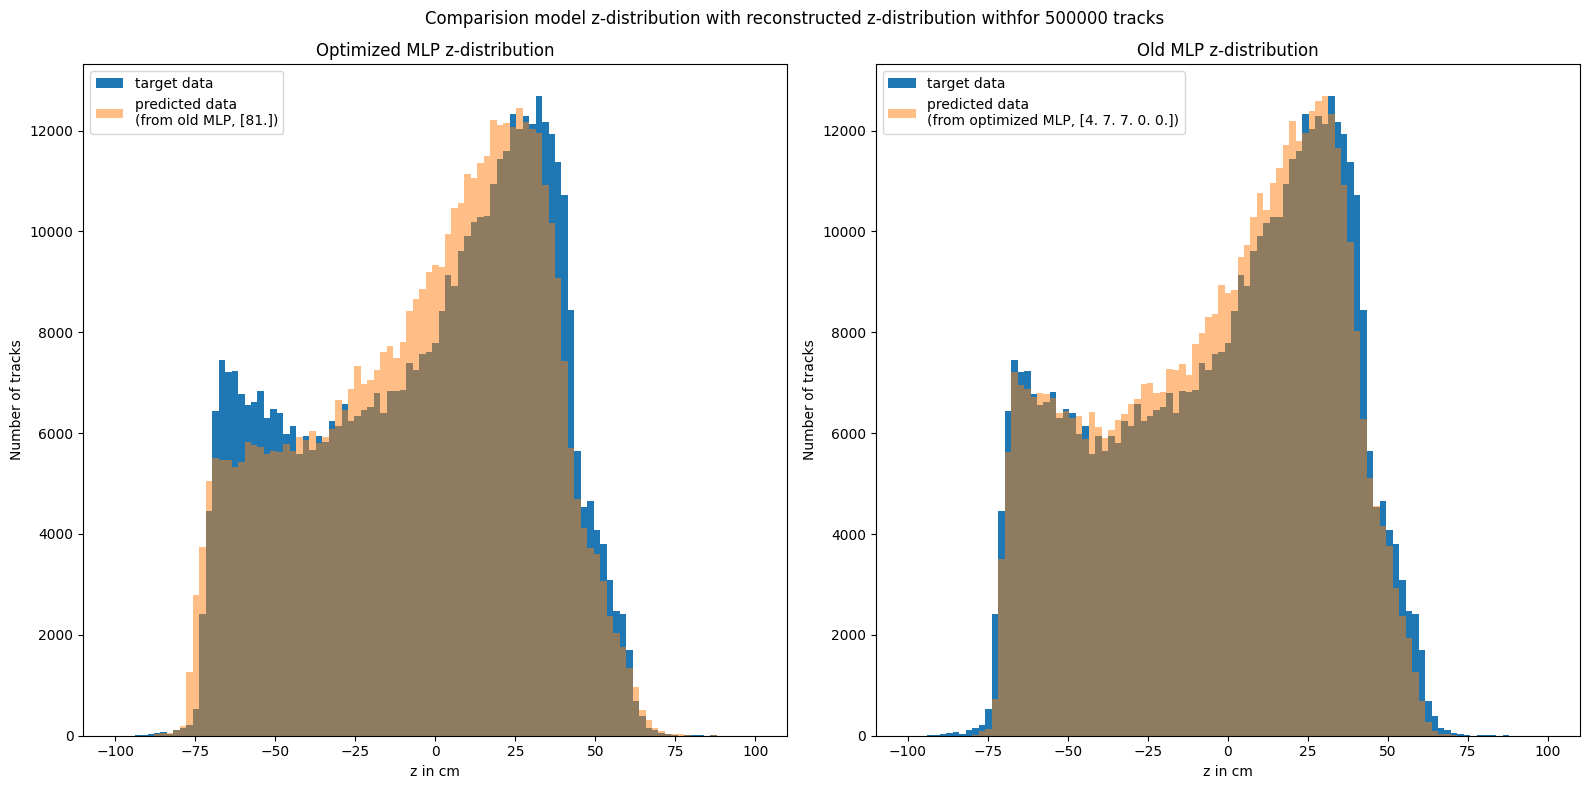

In [94]:
def plot_z_distribution(opt_model, old_model, title, save_name, input, target):

    hist_bins = np.linspace(-100, 100, 100)
    fig, ax = plt.subplots(1, 2)
    fig.set_size_inches(16, 8)

    z_list_opt, true_z_list = data_prep(opt_model, input, target)
    z_list_old, true_z_list = data_prep(old_model, input, target)

    ax[1].set_title(f'Optimized MLP z-distribution')
    ax[0].set_xlabel("z in cm")
    ax[0].set_ylabel("Number of tracks")

    ax[0].set_title(f'Old MLP z-distribution')
    ax[1].set_xlabel("z in cm")
    ax[1].set_ylabel("Number of tracks")
    
    
    ax[1].hist(true_z_list, hist_bins, density=False, alpha = 1, label = 'target data')
    ax[1].hist(z_list_opt, hist_bins, density=False, range=(-10, 10), alpha=0.5, label=f'predicted data \n(from optimized MLP, {opt_parameter})')
    
    ax[0].hist(true_z_list, hist_bins, density=False, alpha = 1, label = 'target data')
    ax[0].hist(z_list_old, hist_bins, density=False, range=(-10, 10), alpha=0.5, label='predicted data \n(from old MLP, [81.])')
    


    ax[1].legend(loc = 'upper left')
    ax[0].legend(loc = 'upper left')
    
    fig.suptitle(title)
    plt.tight_layout()
    fig.savefig(f"{PATH}/plots/{save_name}.png")
    plt.show()


plot_z_distribution(opt_model, old_model, f'Comparision model z-distribution with reconstructed z-distribution withfor {EVALUTAION_DATA_COUNT} tracks',  f"z_distribution{opt_parameter}", val_input, val_target )
